# Preprocess [Thai Common Voice Corpus 8.0](https://commonvoice.mozilla.org/en/datasets)

Notebook by [@tann9949](https://github.com/tann9949).

In [31]:
# %pip install pydub
# %pip install pythainlp==2.3.1
# %pip install ipywidgets

In [32]:
import os
import re
from typing import List, Dict, Tuple

import pandas as pd
from scipy.io import wavfile
from pythainlp.tokenize import word_tokenize

from pydub import AudioSegment
from spell_correction import correct_sentence

# ipython
import IPython.display as ipd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [33]:
cv_root: str = "../data/cv-corpus-8.0-2022-01-19"

train: pd.DataFrame = pd.read_csv(f"{cv_root}/th/train.tsv", delimiter="\t")
train["set"] = "train"
dev: pd.DataFrame = pd.read_csv(f"{cv_root}/th/dev.tsv", delimiter="\t")
dev["set"] = "dev"
test: pd.DataFrame = pd.read_csv(f"{cv_root}/th/test.tsv", delimiter="\t")
test["set"] = "test"
data: pd.DataFrame = pd.read_csv(f"{cv_root}/th/validated.tsv", delimiter="\t")

command: str = "sox {mp3_path} -t wav -r {sr} -c 1 -b 16 - |"

In [34]:
def get_full_path(cv_root: str, path: str) -> str:
    """Get full path from `path` instance in cv data"""
    f_path: str = f"{cv_root}/th/clips/{path}"
    if not os.path.exists(f_path):
        raise FileNotFoundError(f"File `{f_path}` does not exists")
    return f_path

def get_char(texts: List[str]) -> List[str]:
    """Get unique char from list of documents"""
    return sorted(set([char for sent in texts for char in sent]))


def get_audio_len(audio_path: str) -> float:
    """Get audio duration in second"""
    # sr, wav = wavfile.read(audio_path.replace("mp3", "wav").replace("clips", "wav"))
    # return len(wav) / sr
    audio: AudioSegment = AudioSegment.from_mp3(audio_path)
    return len(audio) / 1000  # pydub duration works in ms


def sec_to_hour(second: int) -> str:
    """Convert second to XXH:YYm:ZZs format"""
    minute, second = divmod(second, 60)
    hour, minute = divmod(minute, 60)
    return f"{int(hour)}H:{int(minute)}m:{second:.2f}s"

In [35]:
# Rules mapping obtained from exploring data
mapping_char: Dict[str, str] = {
    r"!": " ",
    r'"': " ",
    r"'": " ",
    r",": " ",
    r"-": " ",
    r"\.{2,}": " ",
    r"\.$": "",  # full stop at end of sentence
    r"([ก-์])\.([ก-์])": r"\1. \2",  # บจก.XXX -> บจก. XXX
    r":": " ",
    r";": " ",
    r"\?": " ",
    r"‘": " ", 
    r"’": " ",
    r"“": " ", 
    r"”": " ",
    r"~": " ",
    r"—": " ",
    r"\.": " ",
    # ADD beacuse unwelcome char_dict
    r'\_': " ",
    r'\|': " ",
}

# text that needs to be fixed
change_text: Dict[str, str] = {
    "common_voice_th_26103939.mp3": "บริษัทจำกัดดาบเพ็ชร์",
    "common_voice_th_27269555.mp3": "ศุนย์การค้า เจ พี ไรวา",
    "common_voice_th_26429486.mp3": "โศรดาพลัดถิ่น ชอุ่ม ปัญจพรรค์",
    "common_voice_th_25668677.mp3": "มิสเตอร์ ลินคอล์น",
    "common_voice_th_25677501.mp3": "โอ้พระเจ้าพวกเขาฆ่า เคนนี่",
    "common_voice_th_25696778.mp3": "ฉันสงสัยว่า ซี เซคชั่น จะได้รับความนิยมมากกว่าการเกิดตามธรรมชาติในวันหนึ่ง",
    "common_voice_th_25728649.mp3": "เนื่องจากการขาดโปรแกรมความผิดพลาด โจฮันน่า จึงตัดสินใจขายการหาประโยชน์ในตลาดมืด",
    "common_voice_th_25700969.mp3": "บรูค วิจารณ์ตัวเองเพราะรอยยิ้ม",
    "common_voice_th_23897115.mp3": "กลุ่มอาการ แอสเพอร์เจอร์ เป็นรูปแบบของออทิสติก",
    "common_voice_th_25705973.mp3": "การเปิดใช้งาน ซอฟต์แม็ก นั้นมีราคาแพงมากเพื่อใช้ในการคำนวณ",
    "common_voice_th_24149507.mp3": "แอสโทเทริฟ ถูกใช้ปูพื้นในสนามเด็กเล่นกลางแจ้ง",
    "common_voice_th_25665768.mp3": "เฟสบุ๊ก รวบรวมข้อมูลเกี่ยวกับผู้ที่ไม่ได้เป็นสมาชิก",
    "common_voice_th_25636404.mp3": "ใครอยู่ ม โปรดพาอ้อมไปกินข้าวที",
    "common_voice_th_25903042.mp3": "ฉันคิดว่ามันพร้อมแล้ว ฉันกล่าว",
    "common_voice_th_26701409.mp3": "จอมพล ป มีแนวคิดว่าราษฎรจะรักชาติของตนมิได้",
    "common_voice_th_26147573.mp3": "จอมพล ป พิบูลสงคราม",
    "common_voice_th_25900743.mp3": "ไม่ใช่เพื่อคุณ กัซซี่กล่าว",
    "common_voice_th_25682485.mp3": "ขอขอบคุณ จะตรวจสอบอย่างแน่นอน",
    "common_voice_th_25885519.mp3": "ไม่ใช่อะไรสลักสำคัญ ทหารตอบกลับ",
    "common_voice_th_25899784.mp3": "ไม่ใช่อย่างน้อยที่สุด เขากล่าว",
    "common_voice_th_25704992.mp3": "การวินิจฉัยโรคจำเป็นต้องทำอย่างละเอียดและรอบคอบ", # การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
    "common_voice_th_25628971.mp3": "เขากำลังทำงานอยู่",  # "เขากำลังทํางานอยู่"
}

# sentence to skip
skip_sentence: Dict[str, str] = {
    "common_voice_th_25683553.mp3": "บางครั้งคนอังกฤษก็ใช้คำว่า whilst แม้ว่ามันจะดูเก่าไปแล้วก็ตาม",
    "common_voice_th_25682645.mp3": "ฉันใช้Flickr ในการเก็บภาพถ่ายออนไลน์ที่สำคัญของฉันเป็นส่วนใหญ่",
    "common_voice_th_25673002.mp3": "Fury X เป็นการ์ดกราฟิกที่ทรงพลังมาก",
    "common_voice_th_25695730.mp3": "Brexiteers เป็นชื่อเล่นที่มอบให้กับผู้ที่สนับสนุนการลงประชามติของ Brexit"
}

skip_rules: List[str] = [
    r"[a-zA-Z]",
]

## Audio EDA

I skip because I no need to virsulize & take too much time to run this cell.

In [36]:
# audios: List[str] = data["path"].map(
#     lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
# audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]plt.hist(audios_len, bins=50)

# plt.xlabel("Time (sec)")
# plt.ylabel("Frequency")
# plt.title("File duration distribution")
# plt.show()

# print(f"Total: {sec_to_hour(np.sum(audios_len))}")
# print(f"Mean: {np.mean(audios_len):.2f}")
# print(f"Std.: {np.std(audios_len):.2f}")
# print(f"Max: {np.max(audios_len):.2f}")
# print(f"Min: {np.min(audios_len):.2f}")

## Transcription EDA

In [37]:
texts: pd.DataFrame = data[["path", "sentence"]]
texts["path"] = texts["path"].map(lambda x: get_full_path(cv_root, x))
texts: List[Tuple[str, str]] = texts.values.tolist()
# texts = [correct_sentence(text) for text in tqdm(texts)]

C:\Users\otash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
_ = [print(f"`{c}`, ", end="") for c in get_char([x[-1] for x in texts])]

` `, `!`, `"`, `'`, `,`, `-`, `.`, `:`, `;`, `?`, `A`, `B`, `C`, `F`, `J`, `K`, `L`, `M`, `X`, `_`, `a`, `b`, `c`, `e`, `f`, `g`, `h`, `i`, `k`, `l`, `m`, `n`, `o`, `p`, `r`, `s`, `t`, `u`, `w`, `x`, `y`, `|`, `~`, `ก`, `ข`, `ฃ`, `ค`, `ฆ`, `ง`, `จ`, `ฉ`, `ช`, `ซ`, `ฌ`, `ญ`, `ฎ`, `ฏ`, `ฐ`, `ฑ`, `ฒ`, `ณ`, `ด`, `ต`, `ถ`, `ท`, `ธ`, `น`, `บ`, `ป`, `ผ`, `ฝ`, `พ`, `ฟ`, `ภ`, `ม`, `ย`, `ร`, `ฤ`, `ล`, `ว`, `ศ`, `ษ`, `ส`, `ห`, `ฬ`, `อ`, `ฮ`, `ฯ`, `ะ`, `ั`, `า`, `ำ`, `ิ`, `ี`, `ึ`, `ื`, `ุ`, `ู`, `เ`, `แ`, `โ`, `ใ`, `ไ`, `ๅ`, `ๆ`, `็`, `่`, `้`, `๊`, `๋`, `์`, `ํ`, `—`, `‘`, `’`, `“`, `”`, 

In [39]:
nxt_btn = widgets.Button(description="Next")
back_btn = widgets.Button(description="Back")
output = widgets.Output()

pattern = r"ํ"
idx = 0

def on_nxt_clicked(b):
    global idx
    is_match = False
    terminate = False
    while not is_match:
        if idx == len(texts) - 1:
            is_match = True
            terminate = True
        f_path, sent = texts[idx]
        matches = re.finditer(pattern, sent)
        n_matches: int = sum([1 for _ in matches])
        if n_matches > 0:
            is_match = True
        idx += 1
    with output:
        if terminate:
            ipd.clear_output()
            print("End of corpus. Resetting...")
            idx = 0
        else:
            ipd.clear_output()
            print(f_path)
            print(f"{sent}")
            !afplay $f_path
            ipd.display(ipd.Audio(f_path))

def on_back_clicked(b):
    global idx
    is_match = False
    terminate = False
    while not is_match:
        if idx == 0:
            is_match = True
            terminate = True
        f_path, sent = texts[idx]
        matches = re.finditer(pattern, sent)
        n_matches: int = sum([1 for _ in matches])
        if n_matches > 0:
            is_match = True
        idx =- 1
    with output:
        if terminate:
            ipd.clear_output()
            idx = 0
        else:
            ipd.clear_output()
            print(f_path)
            print(f"{sent}")
            !afplay $f_path
            ipd.display(ipd.Audio(f_path))


display(nxt_btn, back_btn, output)

nxt_btn.on_click(on_nxt_clicked)
back_btn.on_click(on_back_clicked)

Button(description='Next', style=ButtonStyle())

Button(description='Back', style=ButtonStyle())

Output()

In [40]:
_ = [print("\t".join([x[0], x[-1]])) for x in texts if re.search(r"ํ", x[-1])]

../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25704992.mp3	การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25628971.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25664993.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25689572.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25733924.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25689838.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25704096.mp3	การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_23670291.mp3	การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25733488.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_26429486.mp3	โศรดาพลัดถิ่น - ชอุ่ม ปํญจ

In [41]:
!afplay data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25636404.mp3

## Preprocess Data

In [42]:
def preprocess_text(text: str) -> str:
    """Preprocess text according to `mapping_char`"""
    text = correct_sentence(text)
    for pattern, sub in mapping_char.items():
        text = re.sub(pattern, sub, text)
    text = re.sub(r" +", " ", text)  # merge multiple whitespaces to one
    return text

def is_valid(text: str) -> bool:
    """Validate each utterance"""
    for rule in skip_rules:
        if re.search(rule, text):
            return False
        else:
            return True

In [43]:
texts: pd.DataFrame = data[["path", "sentence"]]
texts["path"] = texts["path"].map(lambda x: get_full_path(cv_root, x))
texts = texts[texts["sentence"].apply(lambda x: is_valid(x))].reset_index(drop=True)
texts["sentence"] = texts["sentence"].map(lambda x: preprocess_text(x))

remove_idx: List[int] = []
for i in tqdm(range(len(texts)), total=len(texts)):
    f_path: str = os.path.basename(texts.loc[i, "path"])
    for name, change in change_text.items():
        if f_path in name:
            print(texts.loc[i, "path"])
            print("\tReplacing", f"`{texts.loc[i, 'sentence']}`...", "with", f"`{change}`...")
            texts.loc[i, "sentence"] = change
            break
    for name in skip_sentence.keys():
        if f_path in name:
            print(texts.loc[i, "path"])
            print(f"\tRemoving `{texts.loc[i, 'sentence']}`...")
            remove_idx.append(i)
            
texts = texts.drop(texts.index[remove_idx])
            
texts["path"] = texts["path"].map(lambda x: x.replace(f"{cv_root}/th/clips/", ""))
texts = texts.reset_index(drop=True)
texts["sentence"] = texts["sentence"].map(lambda x: re.sub(r" +", " ", x).strip())

C:\Users\otash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
Correct ํ + า => ำ
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Replaced
Correct ํ + า => ำ
ๆ Replaced
ๆ Replaced
ๆ Replaced
ๆ Rep

../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25704992.mp3
	Replacing `การวินิจฉัยโรคจำเป็นต้องทำอย่างละเอียดและรอบคอบ`... with `การวินิจฉัยโรคจำเป็นต้องทำอย่างละเอียดและรอบคอบ`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25628971.mp3
	Replacing `เขากำลังทำงานอยู่`... with `เขากำลังทำงานอยู่`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25636404.mp3
	Replacing `ใครอยู่ม โปรดพาอ้อมไปกินข้าวที`... with `ใครอยู่ ม โปรดพาอ้อมไปกินข้าวที`...


../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_26147573.mp3
	Replacing `จอมพล ป พิบูลสงคราม`... with `จอมพล ป พิบูลสงคราม`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25682485.mp3
	Replacing `ขอขอบคุณ จะตรวจสอบอย่างแน่นอน`... with `ขอขอบคุณ จะตรวจสอบอย่างแน่นอน`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25885519.mp3
	Replacing `ไม่ใช่อะไรสลักสำคัญ ทหารตอบกลับ`... with `ไม่ใช่อะไรสลักสำคัญ ทหารตอบกลับ`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25899784.mp3
	Replacing `ไม่ใช่อย่างน้อยที่สุด เขากล่าว`... with `ไม่ใช่อย่างน้อยที่สุด เขากล่าว`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25900743.mp3
	Replacing `ไม่ใช่เพื่อคุณ กัซซี่กล่าว`... with `ไม่ใช่เพื่อคุณ กัซซี่กล่าว`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_25903042.mp3
	Replacing `ฉันคิดว่ามันพร้อมแล้ว ฉันกล่าว`... with `ฉันคิดว่ามันพร้อมแล้ว ฉันกล่าว`...


../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_26103939.mp3
	Replacing `บจก ดาบเพ็ชร์`... with `บริษัทจำกัดดาบเพ็ชร์`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_26429486.mp3
	Replacing `โศรดาพลัดถิ่น ชอุ่ม ปํญจพรรค์`... with `โศรดาพลัดถิ่น ชอุ่ม ปัญจพรรค์`...
../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_26701409.mp3
	Replacing `จอมพล ป มีแนวคิดว่า ราษฎรจะรักชาติของตนมิได้`... with `จอมพล ป มีแนวคิดว่าราษฎรจะรักชาติของตนมิได้`...


100%|██████████| 119931/119931 [00:01<00:00, 98246.65it/s]


../data/cv-corpus-8.0-2022-01-19/th/clips/common_voice_th_27269555.mp3
	Replacing `ศูนย์การค้าเจ พี ไรวา`... with `ศุนย์การค้า เจ พี ไรวา`...


In [44]:
_ = [print(f"\"{c}\", ", end="") for c in get_char([x[1] for x in texts.values.tolist()])]

  6%|▌         | 6634/119980 [29:20<8:21:13,  3.77it/s]


" ", "[", "]", "ก", "ข", "ฃ", "ค", "ฆ", "ง", "จ", "ฉ", "ช", "ซ", "ฌ", "ญ", "ฎ", "ฏ", "ฐ", "ฑ", "ฒ", "ณ", "ด", "ต", "ถ", "ท", "ธ", "น", "บ", "ป", "ผ", "ฝ", "พ", "ฟ", "ภ", "ม", "ย", "ร", "ฤ", "ล", "ว", "ศ", "ษ", "ส", "ห", "ฬ", "อ", "ฮ", "ฯ", "ะ", "ั", "า", "ำ", "ิ", "ี", "ึ", "ื", "ุ", "ู", "เ", "แ", "โ", "ใ", "ไ", "ๅ", "็", "่", "้", "๊", "๋", "์", 

In [45]:
texts[texts["sentence"] == ""]

,path,sentence


In [46]:
texts

,path,sentence
0,common_voice_th_25695281.mp3,ใครเป็นผู้รับ
1,common_voice_th_25695038.mp3,ผู้ชายคือช้างเท้าหน้า แต่ผู้หญิงคือควาญช้าง
2,common_voice_th_25768746.mp3,คุณคือคนที่ดีที่สุด คุณผู้หญิง เขาพูดด้วยท่าที...
3,common_voice_th_25663832.mp3,ลองชิมสลัดนี้ดูสิ
4,common_voice_th_25692662.mp3,คุณสามารถเห็นได้อย่างชัดเจนว่าเธอคือผู้หญิงที่...
...,...,...
119926,common_voice_th_28780144.mp3,คือเป็นการคุยกันกลุ่มเล็ก
119927,common_voice_th_28780164.mp3,คำถามคือ
119928,common_voice_th_28787227.mp3,ความเป็นนวัตกรรม
119929,common_voice_th_30317295.mp3,คากิคืออุ้งตีนหมู


In [47]:
#count duplicated sentences
texts.sentence.value_counts()

รู้สึกอย่างไร ฉันถาม                                                                    15
ไม่มีอะไรให้ดู                                                                          15
ตอนนี้คุณรู้สึกอย่างไร                                                                  14
ฉันจะรู้ได้อย่างไร                                                                      13
คุณพูดอะไร                                                                              13
                                                                                        ..
ขอเสนอแนะทำเอาทุกคนที่ได้ยินมันตกตะลึง                                                   1
เซนต์นิโคลัสนำสารพัดและส้มจีน                                                            1
เท่าที่เห็นนี่จะมีแต่หยิบมาทวีตกันฮะ ไม่ได้หยิบมาแชตระนาว บีบีนี่พิมพ์มันส์สุดแล้วฮะ     1
ทั้งหมดนี้ถูกนำไปอยู่ในหอประชุม                                                          1
ความเป็นนวัตกรรม                                                                         1

In [48]:
#count the dupliation
texts.sentence.value_counts().value_counts()

1     17162
2     16197
4      7178
3      7084
5      2755
6       447
8       179
7       162
9        91
10       28
11       10
12        8
13        3
15        2
14        1
Name: sentence, dtype: int64

In [49]:
#42k unique sentences out of 108k utterances
texts.shape, texts.sentence.nunique()

((119931, 2), 51307)

In [50]:
texts.to_csv('../data/validated_cleaned.tsv', index=False, sep='\t')

In [51]:
preprocessed_test: pd.DataFrame = texts[texts["path"].map(lambda x: x in test["path"].values.tolist())]
preprocessed_test.to_csv("test.csv", index=False)

preprocessed_train: pd.DataFrame = texts[texts["path"].map(lambda x: x not in dev["path"].values.tolist() + test["path"].values.tolist())]
preprocessed_dev: pd.DataFrame = texts[texts["path"].map(lambda x: x in dev["path"].values.tolist())]
preprocessed_test: pd.DataFrame = texts[texts["path"].map(lambda x: x in test["path"].values.tolist())]

preprocessed_train.to_csv("train_cleaned.tsv", index=False, sep='\t')
preprocessed_dev.to_csv("dev_cleaned.tsv", index=False, sep='\t')
preprocessed_test.to_csv("test_cleaned.tsv", index=False, sep='\t')

## Show us some Graph

I skip because I no need to virsulize & take too much time to run this cell.

100%|██████████| 98406/98406 [1:15:52<00:00, 21.62it/s]


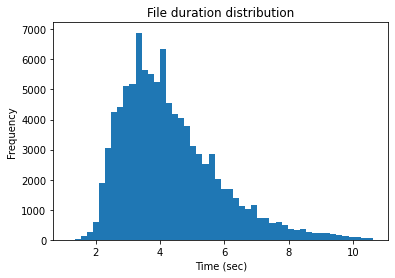

Total: 117H:46m:58.86s
Mean: 4.31
Std.: 1.51
Max: 10.62
Min: 1.15


In [ ]:
# audios: List[str] = preprocessed_train["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
# audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]
# plt.hist(audios_len, bins=50)
# plt.xlabel("Time (sec)")
# plt.ylabel("Frequency")
# plt.title("File duration distribution")
# plt.show()

# print(f"Total: {sec_to_hour(np.sum(audios_len))}")
# print(f"Mean: {np.mean(audios_len):.2f}")
# print(f"Std.: {np.std(audios_len):.2f}")
# print(f"Max: {np.max(audios_len):.2f}")
# print(f"Min: {np.min(audios_len):.2f}")

100%|██████████| 10766/10766 [08:05<00:00, 22.17it/s]


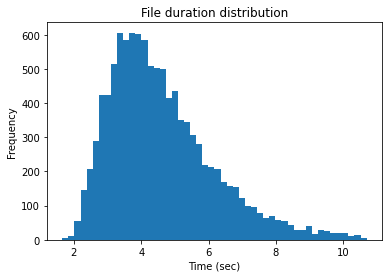

Total: 13H:49m:14.65s
Mean: 4.62
Std.: 1.54
Max: 10.69
Min: 1.66


In [ ]:
# audios: List[str] = preprocessed_dev["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
# audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]
# plt.hist(audios_len, bins=50)
# plt.xlabel("Time (sec)")
# plt.ylabel("Frequency")
# plt.title("File duration distribution")
# plt.show()

# print(f"Total: {sec_to_hour(np.sum(audios_len))}")
# print(f"Mean: {np.mean(audios_len):.2f}")
# print(f"Std.: {np.std(audios_len):.2f}")
# print(f"Max: {np.max(audios_len):.2f}")
# print(f"Min: {np.min(audios_len):.2f}")

100%|██████████| 10759/10759 [08:04<00:00, 22.22it/s]


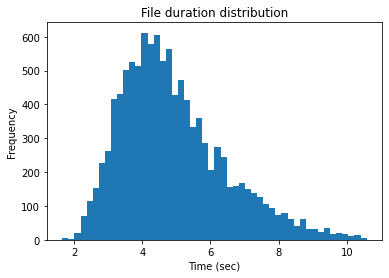

Total: 14H:38m:24.85s
Mean: 4.90
Std.: 1.52
Max: 10.58
Min: 1.66


In [ ]:
# audios: List[str] = preprocessed_test["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
# audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]
# plt.hist(audios_len, bins=50)
# plt.xlabel("Time (sec)")
# plt.ylabel("Frequency")
# plt.title("File duration distribution")
# plt.show()

# print(f"Total: {sec_to_hour(np.sum(audios_len))}")
# print(f"Mean: {np.mean(audios_len):.2f}")
# print(f"Std.: {np.std(audios_len):.2f}")
# print(f"Max: {np.max(audios_len):.2f}")
# print(f"Min: {np.min(audios_len):.2f}")